In [57]:
import numpy as np
import matplotlib.pyplot as plt

def get_data(path):
    file = open(path, "r")
    dataset = np.array([line.strip('\n').split(',') for line in file]).astype(np.float)
    classes = dataset[:,0:1].transpose()[0] # Если первый столбец - номер класса
    unique, counts = np.unique(classes, return_counts=True)
    return dataset, dataset[:,1:], classes

def info(dataset, classes):
    print('Число признаков: ' + str(dataset.shape[1]))
    unique, counts = np.unique(classes, return_counts=True)
    print('Число классов: ' + str(len(unique)))
    print('Объем выборки: ' + str(len(classes)))
    print('Объем выборки для каждого класса: ' + str(counts))
    return

path = "E:/Загрузки/segmentation.data"
dataset_wide, dataset, classes = get_data(path)

info(dataset, classes)

Число признаков: 19
Число классов: 7
Объем выборки: 210
Объем выборки для каждого класса: [30 30 30 30 30 30 30]


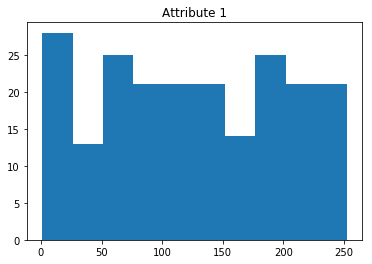

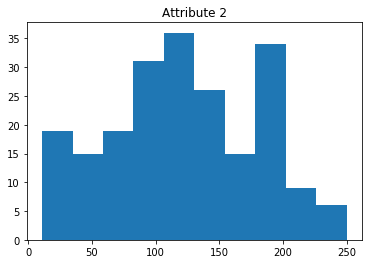

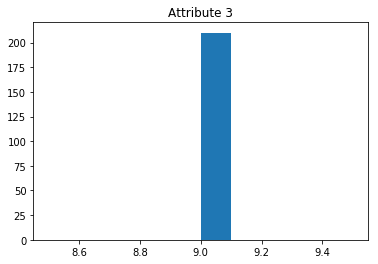

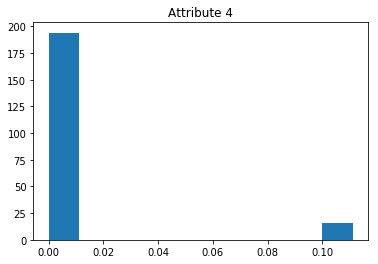

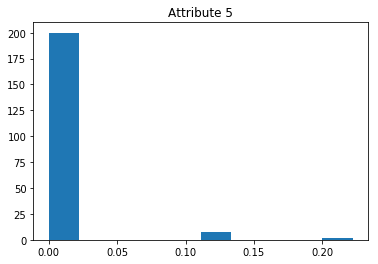

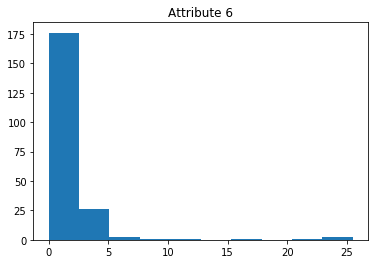

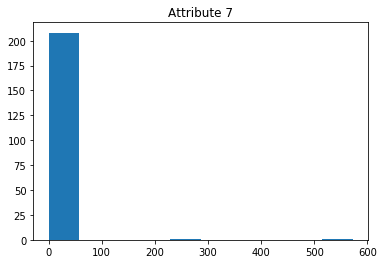

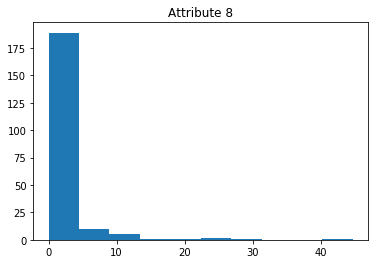

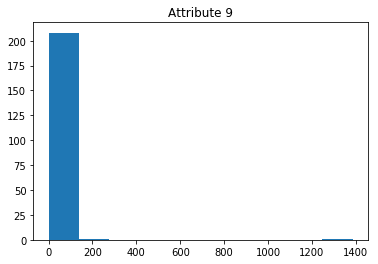

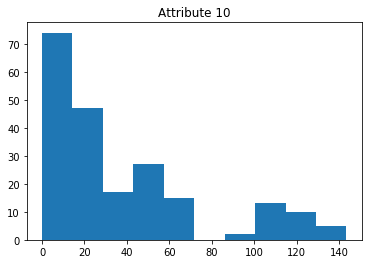

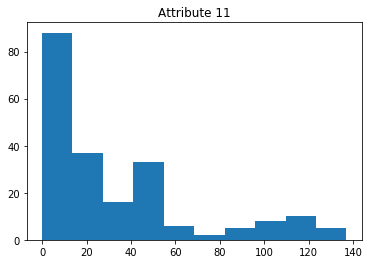

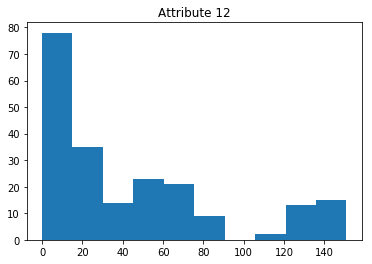

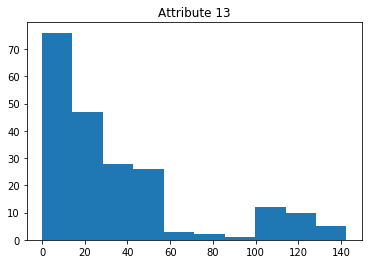

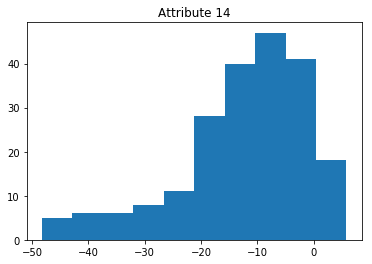

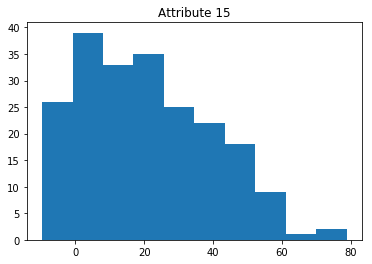

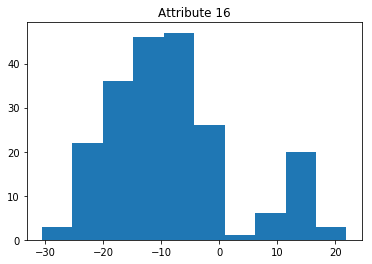

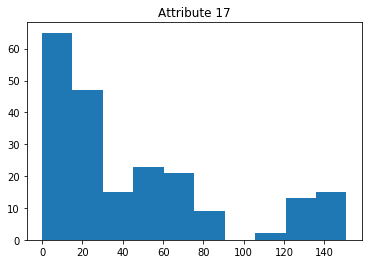

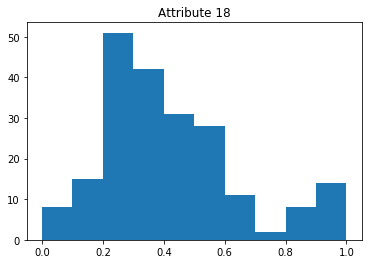

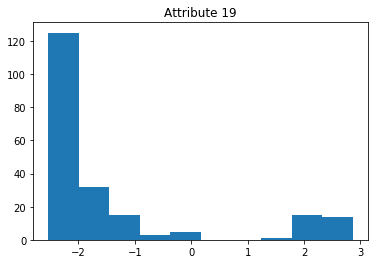

In [58]:
i = 0
for a in dataset.transpose():
    plt.hist(a)
    plt.title('Attribute %s' %(i+1))
    i += 1
    plt.show()

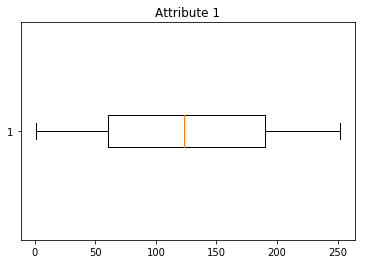

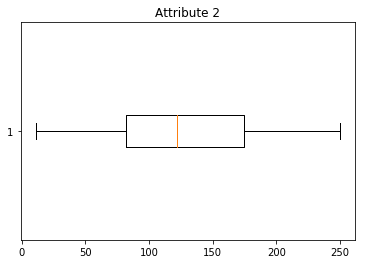

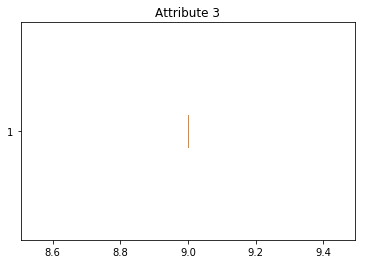

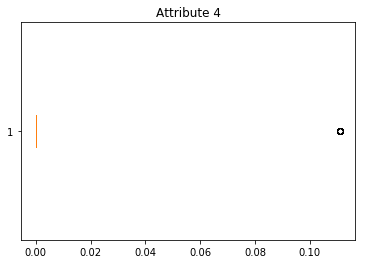

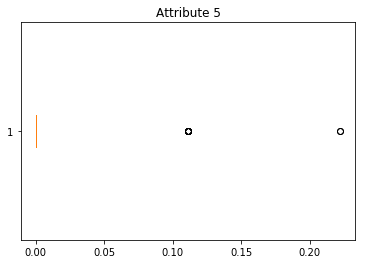

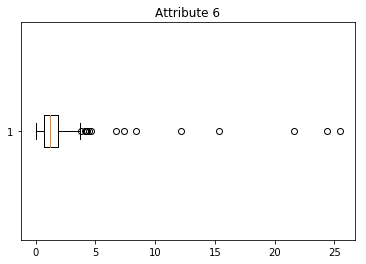

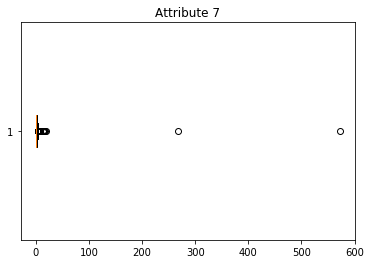

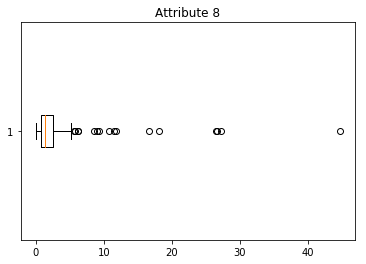

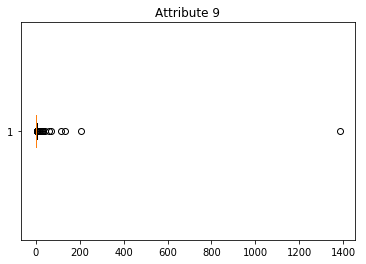

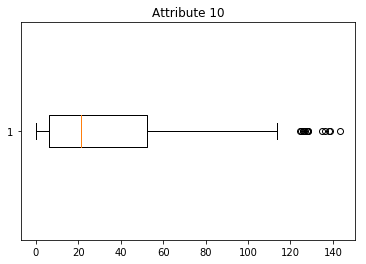

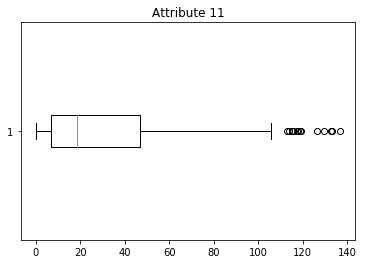

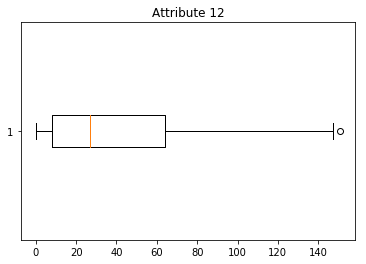

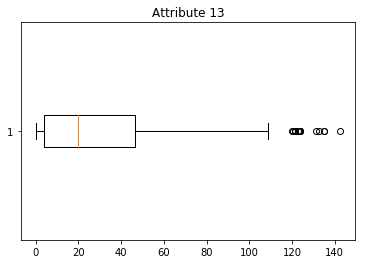

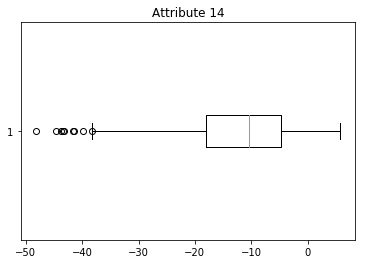

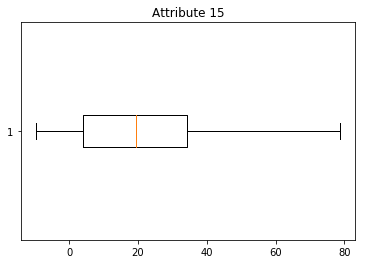

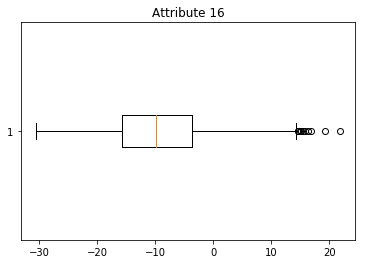

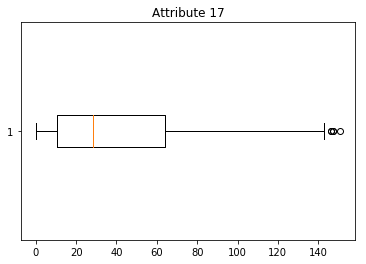

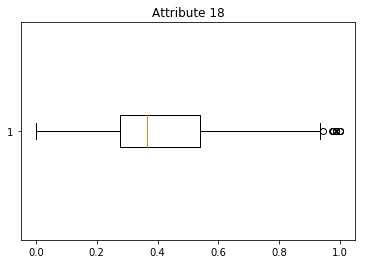

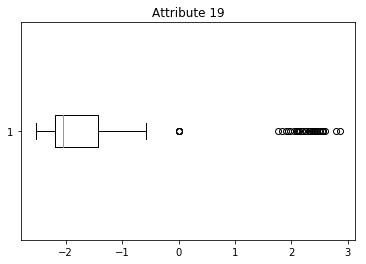

In [59]:
i = 0
for a in dataset.transpose():
    plt.boxplot(a, vert = False)
    plt.title('Attribute %s' %(i+1))
    i += 1
    plt.show()

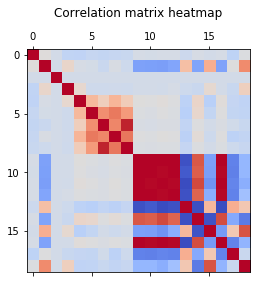

In [60]:
corrs = np.array([[0] * len(dataset[0])] * len(dataset[0])).astype(np.float)

def sigma_sqr(arr):
    res = 0
    for i in range(0, len(arr)):
        res += (arr[i] - np.mean(arr)) * (arr[i] - np.mean(arr))
    return(res)

def covcoef(arr1, arr2): 
    res = 0;
    for i in range(0, np.min(np.array([len(arr1), len(arr2)]))):
        res += (arr1[i] - np.mean(arr1)) * (arr2[i] - np.mean(arr2))
    return(res)    

def corrcoef(arr1, arr2):
    return (covcoef(arr1, arr2) / np.sqrt(sigma_sqr(arr1) * sigma_sqr(arr2)))

for i in range(0, len(corrs)):
    for j in range(0, len(corrs[0])):
        if ((sigma_sqr(dataset.transpose()[i]) == 0) & (sigma_sqr(dataset.transpose()[j]) == 0)):
            corrs[i][j] = 1.0   
        elif ((sigma_sqr(dataset.transpose()[i]) == 0) | (sigma_sqr(dataset.transpose()[j]) == 0)):
            corrs[i][j] = 0.0
        else:
            corrs[i][j] = corrcoef(dataset.transpose()[i], dataset.transpose()[j])
        
plt.matshow(corrs, cmap = "coolwarm")
plt.title("Correlation matrix heatmap\n")
plt.show()

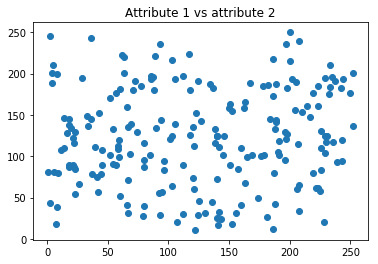

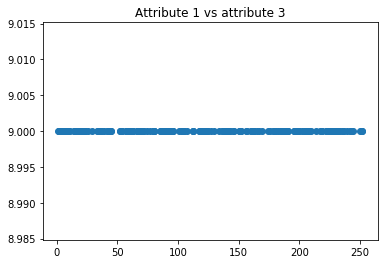

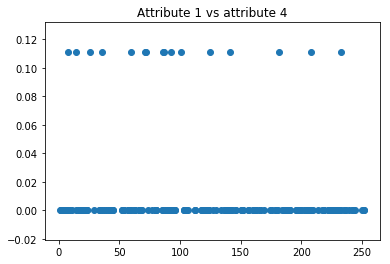

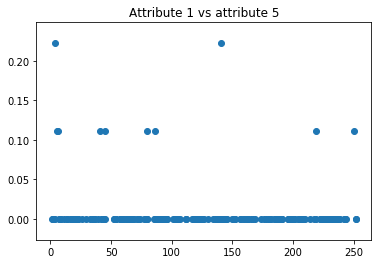

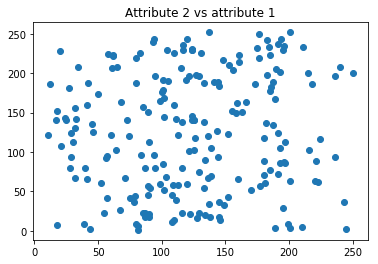

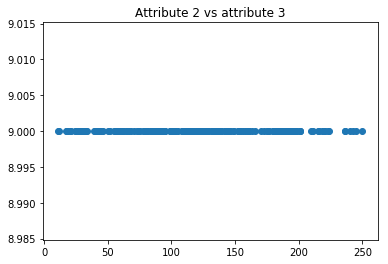

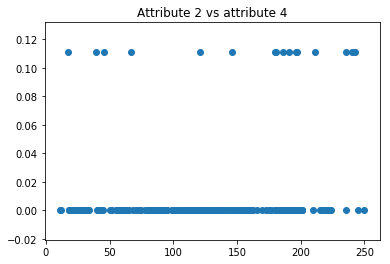

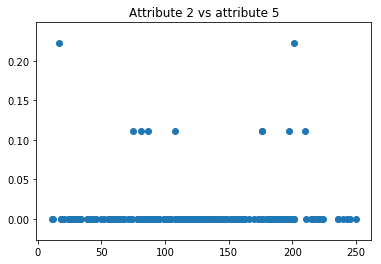

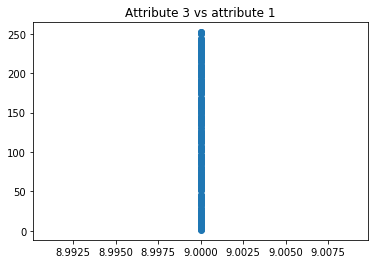

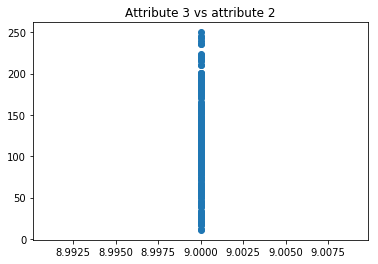

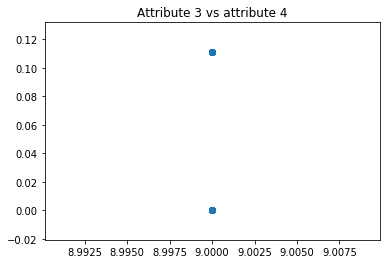

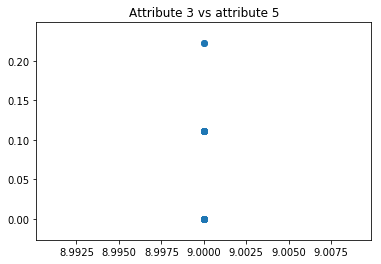

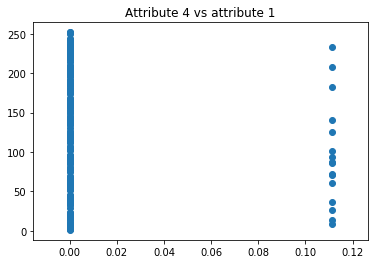

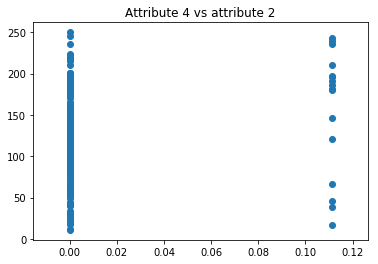

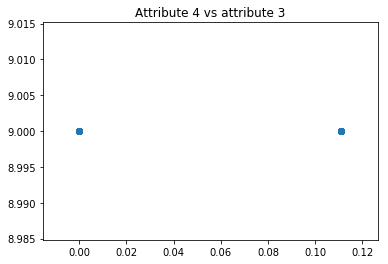

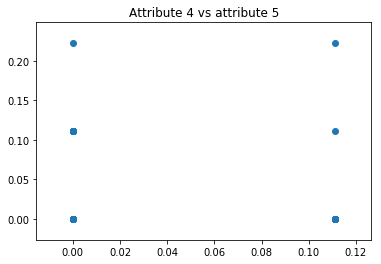

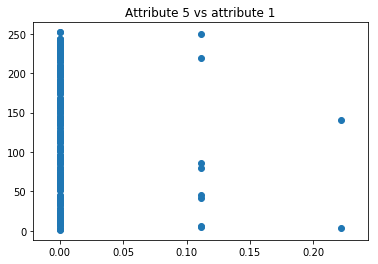

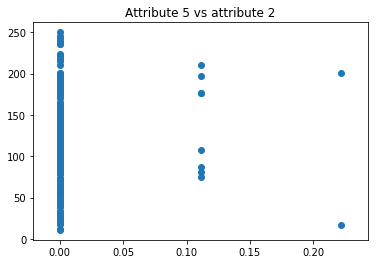

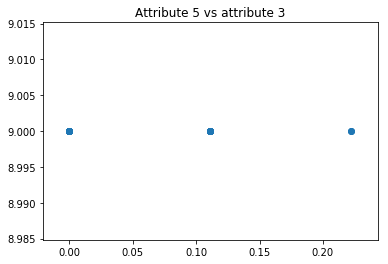

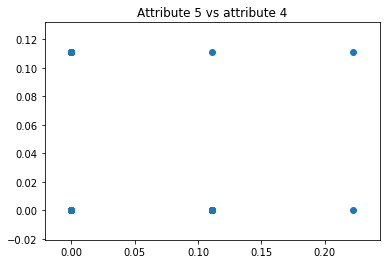

In [61]:
#Диаграммы рассеяния
for a in range(0, 5):
    for b in range(0, 5):
        if (a != b):
            plt.title('Attribute %s vs attribute %s' %((a+1),(b+1)))
            plt.scatter(dataset.transpose()[a], dataset.transpose()[b])
            plt.show()

In [ ]:
#Для обработки

In [62]:
from sklearn.model_selection import train_test_split

def get_TrainTestValid(dataset, classes, train_perc, test_perc):
    train_data, tmp_data, train_classes, tmp_classes = train_test_split(dataset, classes, test_size=(1 - train_perc))
    test_data, valid_data, test_classes, valid_classes = train_test_split(tmp_data, tmp_classes, test_size=(1 - train_perc - (1 - train_perc - test_perc))/(1 - train_perc))
    print('Объем обучающей выборки: ' + str(len(train_data)))
    print('Объем валидационной выборки: ' + str(len(valid_data)))
    print('Объем тестовой выборки: ' + str(len(test_data)))
    print()
    unique, counts = np.unique(train_classes, return_counts=True)
    print('Объемы обучающей выборки для каждого класса: ' + str(counts))
    unique, counts = np.unique(valid_classes, return_counts=True)
    print('Объемы валидационной выборки для каждого класса: ' + str(counts))
    unique, counts = np.unique(test_classes, return_counts=True)
    print('Объемы тестовой выборки для каждого класса: ' + str(counts))
    return train_data, valid_data, test_data, train_classes, valid_classes, test_classes


train_data, valid_data, test_data, train_classes, valid_classes, test_classes = get_TrainTestValid(dataset, classes, 0.6, 0.3)

Объем обучающей выборки: 126
Объем валидационной выборки: 63
Объем тестовой выборки: 21

Объемы обучающей выборки для каждого класса: [18 17 23 19 16 18 15]
Объемы валидационной выборки для каждого класса: [10  9  5  8  9 10 12]
Объемы тестовой выборки для каждого класса: [2 4 2 3 5 2 3]


In [63]:
from sklearn.preprocessing import StandardScaler

def standartize(data_to_fit, data_to_transform):
    scaler = StandardScaler()
    scaler.fit(data_to_fit)
    return scaler.transform(data_to_transform)

train_copy = np.array(train_data)

train_data_standartized = standartize(train_copy, train_data)
valid_data_standartized = standartize(train_copy, valid_data)
test_data_standartized = standartize(train_copy, test_data)

In [64]:
import tensorflow as tf
#import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping

In [77]:
classif = Sequential()

in_dim = np.shape(train_data_standartized)[1]

layer1count = 10
layer2count = 20
layer1AH = 'sigmoid'
layer2AH = 'sigmoid'

moment = 0.0

classif.add(Dense(layer1count, activation=layer1AH, input_dim=in_dim, kernel_initializer='he_normal'))
classif.add(Dense(layer2count, activation=layer2AH, kernel_initializer='he_normal'))
classif.add(Dense(1))

opti = optimizers.SGD(lr=0.001, momentum=moment, decay=0.0, nesterov=False)

classif.compile(loss='mean_squared_error', optimizer=opti, metrics=['mean_squared_error', 'accuracy'])
classif.build()

In [78]:
b_size = len(train_data_standartized)    #или число при mini_batch, 1 или None при Stohastic

f_predict_before = classif.predict(test_data_standartized, batch_size=None, verbose=0, steps=None)

stop = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=25000, verbose=0, restore_best_weights=False)

history = classif.fit(
    train_data_standartized, train_classes, batch_size=b_size, epochs=100000, callbacks=[stop],
    verbose=0, validation_data=(valid_data_standartized, valid_classes), shuffle=False
)

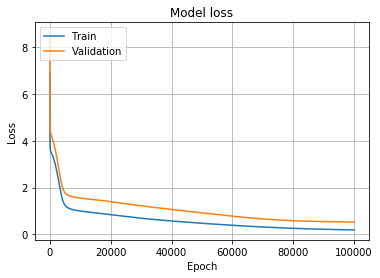

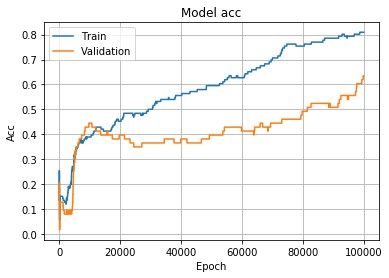

In [79]:
f_predict = classif.predict(test_data_standartized, batch_size=None, verbose=0, steps=None)
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()
    
def show_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model acc')
    plt.ylabel('Acc')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()

show_loss(history)
show_acc(history)

0.4725346267223358